In [1]:
#@title Download pytrends
!pip install pytrends

/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Trend Analysis Sentiment: Neutral
Percentage Trend Analysis: -72.73%
Sentiment from Percentage Change: Negative


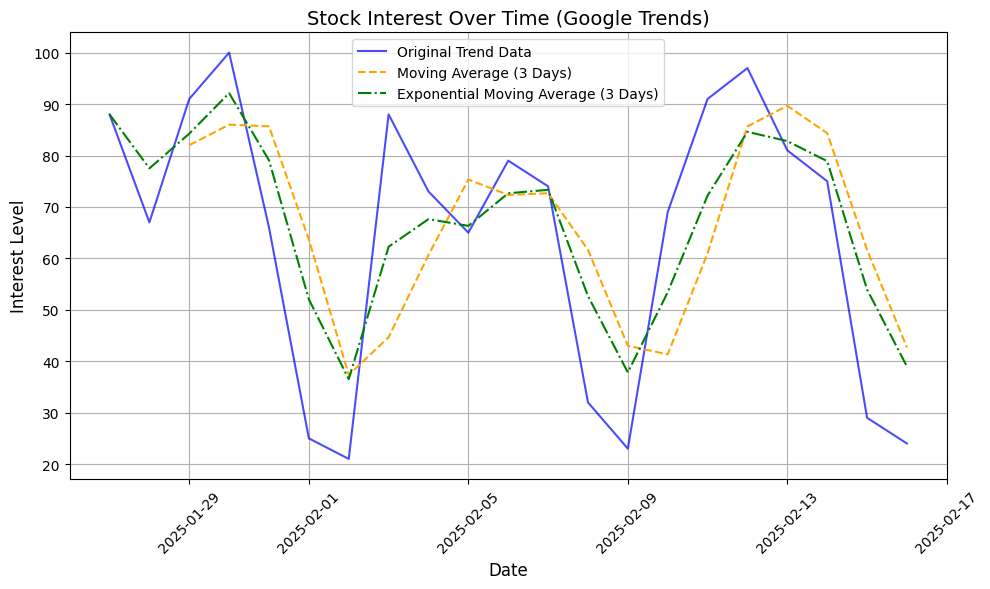

In [2]:
#@title Calculate MA, EMA, Google trend for a given stock and plot those
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from datetime import date, timedelta

# Function to download Google Trends data for a given term and time period
def download_trend_data(search_term, timeframe='now 7-d', geo='', gprop=''):
    """
    Downloads Google Trends data for a given search term, timeframe, and other parameters.

    Parameters:
    search_term (str): The search term to query on Google Trends.
    timeframe (str): Timeframe for the trends (e.g., 'now 7-d', 'today 3-m', '2020-01-01 2021-12-31').
    geo (str): Geographical region (e.g., 'US' for the United States). Leave empty for global data.
    gprop (str): Type of data (e.g., '' for general search data, 'news', 'images', etc.).

    Returns:
    pd.DataFrame: A DataFrame containing the trend data for the search term.
    """

    pytrends = TrendReq(hl='en-US', tz=360)  # Initialize pytrends object
    pytrends.build_payload([search_term], cat=0, timeframe=timeframe, geo=geo, gprop=gprop)

    # Download interest over time data
    trend_data = pytrends.interest_over_time()

    # Return the DataFrame containing trend data
    return trend_data


# Function to calculate Exponential Moving Average (EMA)
def calculate_ema(trend_data, window=3):
    """
    Calculates the Exponential Moving Average (EMA) of the trend data.

    Parameters:
    trend_data (pd.Series): The time series of Google Trends data for a given stock.
    window (int): The window size for the EMA calculation.

    Returns:
    pd.Series: The EMA values.
    """
    return trend_data.ewm(span=window, adjust=False).mean()


# Function for Trend Analysis (based on the trend direction)
def trend_analysis(trend_data, moving_average_window=3):
    """
    Analyzes the trend direction of a given stock based on Google Trends data.

    Parameters:
    trend_data (pd.Series): The time series of Google Trends data for a given stock.
    moving_average_window (int): The window size for calculating the moving average.

    Returns:
    str: Sentiment of the stock trend ('Positive', 'Negative', 'Neutral')
    """

    # Step 1: Calculate the moving average to smooth out fluctuations
    trend_data_ma = trend_data.rolling(window=moving_average_window).mean()

    # Step 2: Compare the start and end values of the moving average to determine trend direction
    start_value = trend_data_ma.iloc[0]
    end_value = trend_data_ma.iloc[-1]

    # Step 3: Determine sentiment based on trend direction
    if end_value > start_value:
        sentiment = 'Positive'
    elif end_value < start_value:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment


# Function for Percentage Trend Analysis (percentage change between first and last value)
def percentage_trend_analysis(trend_data):
    """
    Analyzes the percentage change in the stock trend over the given period.

    Parameters:
    trend_data (pd.Series): The time series of Google Trends data for a given stock.

    Returns:
    float: Percentage change in trend
    str: Sentiment based on percentage change ('Positive', 'Negative', 'Neutral')
    """

    # Step 1: Calculate the percentage change from the first to the last value
    start_value = trend_data.iloc[0]
    end_value = trend_data.iloc[-1]
    percentage_change = ((end_value - start_value) / start_value) * 100

    # Step 2: Determine sentiment based on percentage change
    if percentage_change > 0:
        sentiment = 'Positive'
    elif percentage_change < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return percentage_change, sentiment


# Function for Trend Visualization
def visualize_trend(trend_data, moving_average_window=3, ema_window=3):
    """
    Visualizes the trend of a given stock with the moving average, EMA, and original trend data.

    Parameters:
    trend_data (pd.Series): The time series of Google Trends data for a given stock.
    moving_average_window (int): The window size for calculating the moving average.
    ema_window (int): The window size for calculating the Exponential Moving Average.
    """

    # Step 1: Calculate the moving average for the trend data
    trend_data_ma = trend_data.rolling(window=moving_average_window).mean()

    # Step 2: Calculate the Exponential Moving Average (EMA)
    trend_data_ema = calculate_ema(trend_data, window=ema_window)

    # Step 3: Plot the raw trend data, the moving average, and the EMA on the same graph
    plt.figure(figsize=(10, 6))
    plt.plot(trend_data, label='Original Trend Data', color='blue', alpha=0.7)
    plt.plot(trend_data_ma, label=f'Moving Average ({moving_average_window} Days)', color='orange', linestyle='--')
    plt.plot(trend_data_ema, label=f'Exponential Moving Average ({ema_window} Days)', color='green', linestyle='-.')

    # Step 4: Add labels, title, and legends
    plt.title('Stock Interest Over Time (Google Trends)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Interest Level', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def get_timeframe(days_back):
    """
    Generates a Google Trends timeframe string for the specified number of days back.

    The timeframe ends on today and goes back 'days_back' days.

    Parameters:
    days_back (int): The number of days to go back from today.

    Returns:
    str: The Google Trends timeframe string in the format 'YYYY-MM-DD YYYY-MM-DD'.
    """

    end_date = date.today()
    start_date = end_date - timedelta(days=days_back)

    timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"

    return timeframe


# Example Usage
if __name__ == "__main__":
    # Download Google Trends data for "Tesla stock" over the past 20 days
    trend_df = download_trend_data('Tesla stock', timeframe=get_timeframe(20))

    # Check if data is available (if empty, handle appropriately)
    if trend_df.empty:
        print("No trend data available for the given term.")
    else:
        # Perform trend analysis and print the result
        sentiment = trend_analysis(trend_df['Tesla stock'], moving_average_window=3)
        print(f"Trend Analysis Sentiment: {sentiment}")

        # Perform percentage trend analysis and print the result
        percentage_change, sentiment_percentage = percentage_trend_analysis(trend_df['Tesla stock'])
        print(f"Percentage Trend Analysis: {percentage_change:.2f}%")
        print(f"Sentiment from Percentage Change: {sentiment_percentage}")

        # Visualize the trend with moving average and EMA
        visualize_trend(trend_df['Tesla stock'], moving_average_window=3, ema_window=3)


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Trend Analysis Sentiment: Negative
Percentage Trend Analysis: -71.59%
Sentiment from Percentage Change: Negative


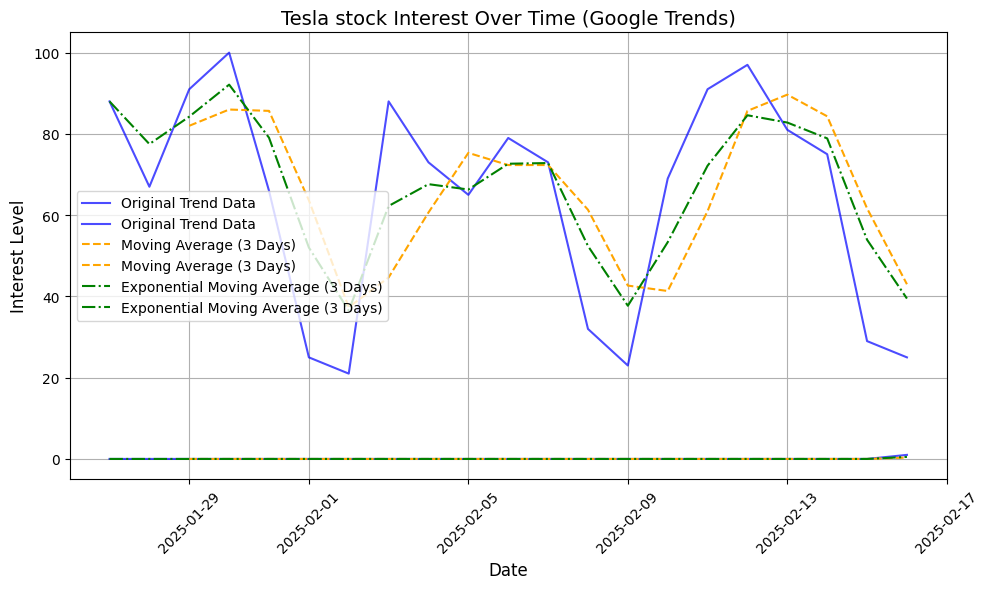

In [9]:
#@title Calculate EMA,MA, Trend analysis for a given stock and visualize the data using Python OOP
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from datetime import date, timedelta

class StockTrendAnalysis:
    def __init__(self, search_term, timeframe='today 7-d', geo='', gprop=''):
        """
        Initializes the StockTrendAnalysis class with the search term and trend parameters.

        Parameters:
        search_term (str): The search term to query on Google Trends.
        timeframe (str): Timeframe for the trends (default is 'now 7-d').
        geo (str): Geographical region (default is empty for global data).
        gprop (str): Type of data (default is empty for general search data).
        """
        self.search_term = search_term
        self.timeframe = timeframe
        self.geo = geo
        self.gprop = gprop
        self.trend_data = None

    def download_trend_data(self):
        """
        Downloads Google Trends data for a given search term, timeframe, and other parameters.

        Returns:
        pd.DataFrame: A DataFrame containing the trend data for the search term.
        """
        pytrends = TrendReq(hl='en-US', tz=360)  # Initialize pytrends object
        pytrends.build_payload([self.search_term], cat=0, timeframe=self.timeframe, geo=self.geo, gprop=self.gprop)

        # Download interest over time data
        self.trend_data = pytrends.interest_over_time()
        return self.trend_data

    def calculate_ema(self, trend_data, window=3):
        """
        Calculates the Exponential Moving Average (EMA) of the trend data.

        Parameters:
        trend_data (pd.Series): The time series of Google Trends data for a given stock.
        window (int): The window size for the EMA calculation.

        Returns:
        pd.Series: The EMA values.
        """
        return trend_data.ewm(span=window, adjust=False).mean()

    def trend_analysis(self, moving_average_window=3):
        """
        Analyzes the trend direction of a given stock based on Google Trends data.

        Parameters:
        moving_average_window (int): The window size for calculating the moving average.

        Returns:
        str: Sentiment of the stock trend ('Positive', 'Negative', 'Neutral')
        """
        trend_data_ma = self.trend_data[self.search_term].rolling(window=moving_average_window).mean() # Access the correct column by name

        # Get the first and last valid (non-NaN) values from the moving average Series
        start_value = trend_data_ma.dropna().iloc[0]
        end_value = trend_data_ma.dropna().iloc[-1]

        if end_value > start_value:
            sentiment = 'Positive'
        elif end_value < start_value:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return sentiment


    def percentage_trend_analysis(self):
        """
        Analyzes the percentage change in the stock trend over the given period.

        Returns:
        float: Percentage change in trend
        str: Sentiment based on percentage change ('Positive', 'Negative', 'Neutral')
        """
        # Access the specific column using the search term
        start_value = self.trend_data[self.search_term].iloc[0]
        end_value = self.trend_data[self.search_term].iloc[-1]
        percentage_change = ((end_value - start_value) / start_value) * 100

        if percentage_change > 0:
            sentiment = 'Positive'
        elif percentage_change < 0:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return percentage_change, sentiment


    def visualize_trend(self, moving_average_window=3, ema_window=3):
      """
        Visualizes the trend of a given stock with the moving average, EMA, and original trend data.

      Parameters:
      moving_average_window (int): The window size for calculating the moving average.
      ema_window (int): The window size for calculating the Exponential Moving Average.
      """
      # Step 1: Calculate the moving average for the trend data
      trend_data_ma = self.trend_data.rolling(window=moving_average_window).mean()

      # Step 2: Calculate the Exponential Moving Average (EMA)
      trend_data_ema = self.calculate_ema(self.trend_data, window=ema_window)

      # Step 3: Plot the raw trend data, the moving average, and the EMA on the same graph
      plt.figure(figsize=(10, 6))

      # Plot Original Trend Data with label
      plt.plot(self.trend_data, label='Original Trend Data', color='blue', alpha=0.7)

      # Plot Moving Average with label
      plt.plot(trend_data_ma, label=f'Moving Average ({moving_average_window} Days)', color='orange', linestyle='--')

      # Plot Exponential Moving Average (EMA) with label
      plt.plot(trend_data_ema, label=f'Exponential Moving Average ({ema_window} Days)', color='green', linestyle='-.')

      # Step 4: Add labels, title, and legends
      plt.title(f'{self.search_term} Interest Over Time (Google Trends)', fontsize=14)
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('Interest Level', fontsize=12)
      plt.xticks(rotation=45)

      plt.legend()

      plt.grid(True)
      plt.tight_layout()
      plt.show()

    @staticmethod
    def get_timeframe(days_back):
        """
        Generates a Google Trends timeframe string for the specified number of days back.

        Parameters:
        days_back (int): The number of days to go back from today.

        Returns:
        str: The Google Trends timeframe string in the format 'YYYY-MM-DD YYYY-MM-DD'.
        """
        end_date = date.today()
        start_date = end_date - timedelta(days=days_back)
        timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"
        return timeframe


# Example Usage
if __name__ == "__main__":
    # Create an instance of StockTrendAnalysis class for "Tesla stock"
    trend_analysis_obj = StockTrendAnalysis(search_term='Tesla stock', timeframe=StockTrendAnalysis.get_timeframe(20))

    # Download Google Trends data for "Tesla stock" over the past 20 days
    trend_data = trend_analysis_obj.download_trend_data()

    # Perform trend analysis and print the result
    sentiment = trend_analysis_obj.trend_analysis(moving_average_window=3)
    print(f"Trend Analysis Sentiment: {sentiment}")

    # Perform percentage trend analysis and print the result
    percentage_change, sentiment_percentage = trend_analysis_obj.percentage_trend_analysis()
    print(f"Percentage Trend Analysis: {percentage_change:.2f}%")
    print(f"Sentiment from Percentage Change: {sentiment_percentage}")

    # Visualize the trend with moving average and EMA
    trend_analysis_obj.visualize_trend(moving_average_window=3, ema_window=3)


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
[*********************100%***********************]  1 of 1 completed


Trend Data Head:
        date  Tesla stock  isPartial  Trend_Percentage
0 2024-11-16           27      False               NaN
1 2024-11-17           18      False        -33.333333
2 2024-11-18           79      False        338.888889
3 2024-11-19           71      False        -10.126582
4 2024-11-20           63      False        -11.267606
Detected ticker symbol: TSLA

Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    61 non-null     datetime64[ns]
 1   Close   61 non-null     float64       
 2   High    61 non-null     float64       
 3   Low     61 non-null     float64       
 4   Open    61 non-null     float64       
 5   Volume  61 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.0 KB
None

trend Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries

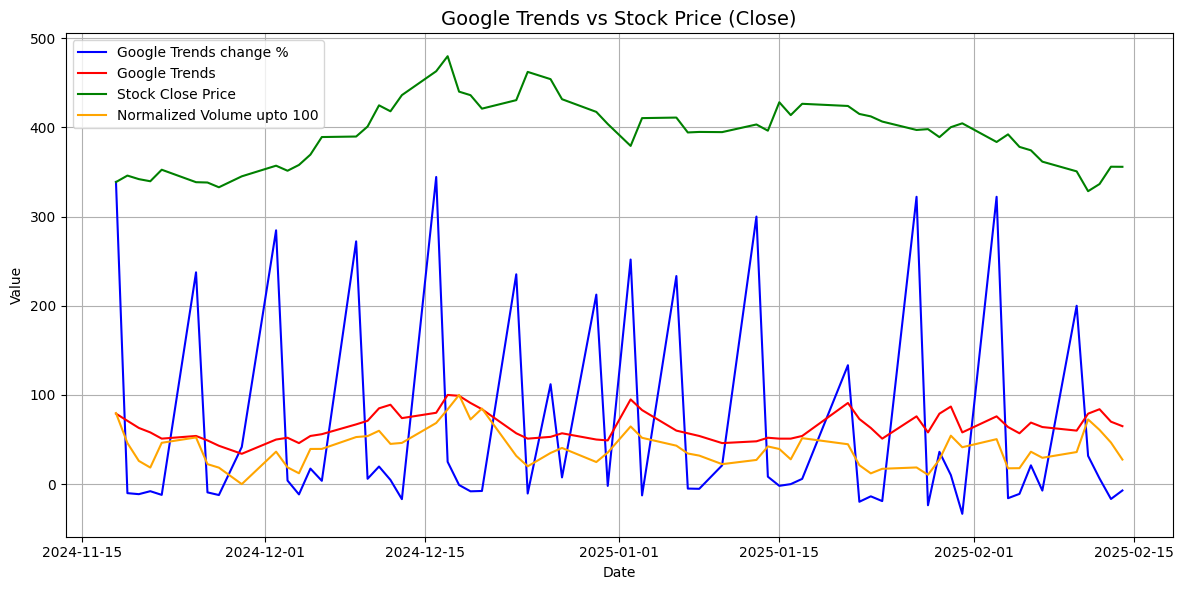

In [17]:
#@title Merge google trend with stock OHLCV data
import pandas as pd
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import time  # Import the time module for pausing

# Download Google Trends Data (as a function)
def download_trend_data(search_term, timeframe='today 3-m', geo='', gprop=''):
    """
    Downloads Google Trends data for a given search term and timeframe.

    Parameters:
    search_term (str): The term to query in Google Trends (e.g., "Tesla stock").
    timeframe (str): Timeframe for the trends data (e.g., 'today 3-m', '2020-01-01 2021-12-31').
    geo (str): Geographical region for the trends (e.g., 'US').
    gprop (str): The property type (e.g., 'news' for news-related trends).

    Returns:
    pd.DataFrame: DataFrame containing the Google Trends data.
    """
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([search_term], cat=0, timeframe=timeframe, geo=geo, gprop=gprop)
    trend_data = pytrends.interest_over_time()

    return trend_data

# Calculate trend percetnage
def calculate_trend_percentage(trend_data):
    """
    Calculates the percentage change in the trend over the given period.

    Parameters:
    trend_data (pd.Dataframe): The Dataframe for Google Trends data for a given stock.

    Returns:
    pd.DataFrame: DataFrame containing the Google Trends data with Trend_Percentage column added.
    """
    trend_data['Trend_Percentage'] = trend_data['Tesla stock'].pct_change() * 100
    return trend_data

# Download OHLCV data from Yahoo Finance
def download_ohlcv_data(ticker, start_date, end_date):
    """
    Downloads OHLCV data from Yahoo Finance.

    Parameters:
    ticker (str): The stock ticker (e.g., 'TSLA' for Tesla).
    start_date (str): Start date of the data in 'YYYY-MM-DD' format.
    end_date (str): End date of the data in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: DataFrame containing OHLCV data.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def align_data(trend_data, stock_data):
    """
    Aligns Google Trends data with stock OHLCV data based on the date index.

    Parameters:
    trend_data (pd.DataFrame): DataFrame containing Google Trends data.
    stock_data (pd.DataFrame): DataFrame containing OHLCV data.

    Returns:
    pd.DataFrame: Merged DataFrame with both Google Trends and stock OHLCV data.
    """
    # Reset index of stock_data to single-level index with 'Date' as a column
    stock_data = stock_data.reset_index()

    # Convert 'Date' column in both trend_data and stock_data to datetime format (if not already)
    trend_data.index = pd.to_datetime(trend_data.index)  # Make sure trend_data index is datetime
    # Reset the index to make 'Date' a column instead of an index
    trend_data.reset_index(inplace=True)
    # Rename the newly created index column to 'Date'
    trend_data.rename(columns={'index': 'Date'}, inplace=True)
    print("Trend Data Head:")
    print(trend_data.head())
    # Rename the column name from date to Date in trend data
    trend_data.columns = trend_data.columns.str.replace('date', 'Date')
    # Convert the 'Date' column in trend_data to datetime (if it's not already)
    trend_data['Date'] = pd.to_datetime(trend_data['Date'])

    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Convert stock_data 'Date' column to datetime
    # Flatten the multi-level column index into single-level
    stock_data.columns = ['_'.join(col) for col in stock_data.columns]

    # Dynamically detect the second level of the column name (which is the ticker symbol)
    ticker_symbol = stock_data.columns[-1].split('_')[1]  # Extract the ticker symbol from the first column name
    print(f"Detected ticker symbol: {ticker_symbol}")
    # Replace the ticker symbol dynamically from all column names
    stock_data.columns = stock_data.columns.str.replace(f"_{ticker_symbol}", "")

    # Rename the 'Date_' column to 'Date'
    stock_data.columns = stock_data.columns.str.replace('Date_', 'Date')
    # Ensure that both 'Date' columns are of type datetime64[ns]
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Convert 'Date' in stock_data to datetime64
    trend_data['Date'] = pd.to_datetime(trend_data['Date'])  # Convert 'Date' in trend_data to datetime64


    print("\nStock Data Info:")
    print(stock_data.info())
    print("\ntrend Data Info:")
    print(trend_data.info())
    # Merge Google Trends and OHLCV data on the 'Date' column
    merged_data = pd.merge(stock_data, trend_data, on='Date', how='inner')

    # Set 'Date' column as index for merged_data
    merged_data = merged_data.set_index('Date')

    # Ensure there are no missing values
    merged_data = merged_data.dropna()

    return merged_data

# Normalize stock volume
def normalize_volume(stock_data):
    """
    Normalizes the volume of the stock data.

    Parameters:
    stock_data (pd.DataFrame): DataFrame containing OHLCV data.

    Returns:
    pd.DataFrame: DataFrame with normalized volume.
    """
    volume_min = stock_data['Volume'].min()
    volume_max = stock_data['Volume'].max()
    stock_data['VolumeNormalized'] = ((stock_data['Volume'] - volume_min) / (volume_max - volume_min)) * 100
    return stock_data

# Calculate correlation
def calculate_correlation(merged_data):
    """
    Calculate Pearson correlation between Google Trends data and stock OHLCV data.

    Parameters:
    merged_data (pd.DataFrame): DataFrame containing both Google Trends and OHLCV data.

    Returns:
    pd.Series: Correlation between Google Trends and stock OHLCV columns.
    """
    # Correlate Google Trends data ('Trend_Percentage') with stock data
    correlation = merged_data.corr()

    return correlation

# Step 5: Visualization (optional)
def plot_correlation(merged_data):
    """
    Visualizes the relationship between Google Trends and stock data.

    Parameters:
    merged_data (pd.DataFrame): DataFrame containing both Google Trends and stock OHLCV data.
    """
    print("\nMerged Data Head:")
    print(merged_data.head())  # Print the first few rows of merged_data
    volume_min = merged_data['Volume'].min()
    volume_max = merged_data['Volume'].max()
    merged_data['VolumeNormalized'] = ((merged_data['Volume'] - volume_min) / (volume_max - volume_min)) * 100

    # Plot Google Trends data vs stock close price
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data.index, merged_data['Trend_Percentage'], label='Google Trends change %', color='blue')
    plt.plot(merged_data.index, merged_data['Tesla stock'], label='Google Trends', color='red')
    plt.plot(merged_data.index, merged_data['Close'], label='Stock Close Price', color='green')
    plt.plot(merged_data.index, merged_data['VolumeNormalized'], label='Normalized Volume upto 100', color='orange')
    plt.title('Google Trends vs Stock Price (Close)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example Usage
if __name__ == "__main__":
    # Download Google Trends data for "Tesla stock" over the past 3 months (daily data)
    trend_df = download_trend_data('Tesla stock', timeframe='today 3-m')

    # Calculate trend percentage
    trend_df = calculate_trend_percentage(trend_df)

    # Download stock OHLCV data for Tesla
    stock_data = download_ohlcv_data('TSLA', start_date='2024-11-15', end_date='2025-02-15')

    # Normalize Volume data
    #stock_data = normalize_volume(stock_data)

    # Align the data
    merged_data = align_data(trend_df, stock_data)

    # Calculate the correlation between Google Trends and stock data
    correlation = calculate_correlation(merged_data)
    print("Correlation between Google Trends and Stock Data:")
    print(correlation)

    # Plot the trends and stock data
    plot_correlation(merged_data)

/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
[*********************100%***********************]  1 of 1 completed



Stock Data Head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    61 non-null     datetime64[ns]
 1   Close   61 non-null     float64       
 2   High    61 non-null     float64       
 3   Low     61 non-null     float64       
 4   Open    61 non-null     float64       
 5   Volume  61 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.0 KB
None

trend Data Head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              21 non-null     datetime64[ns]
 1   Tesla stock       21 non-null     int64         
 2   isPartial         21 non-null     bool          
 3   Trend_Percentage  20 non-null     float64       
dtypes: bo

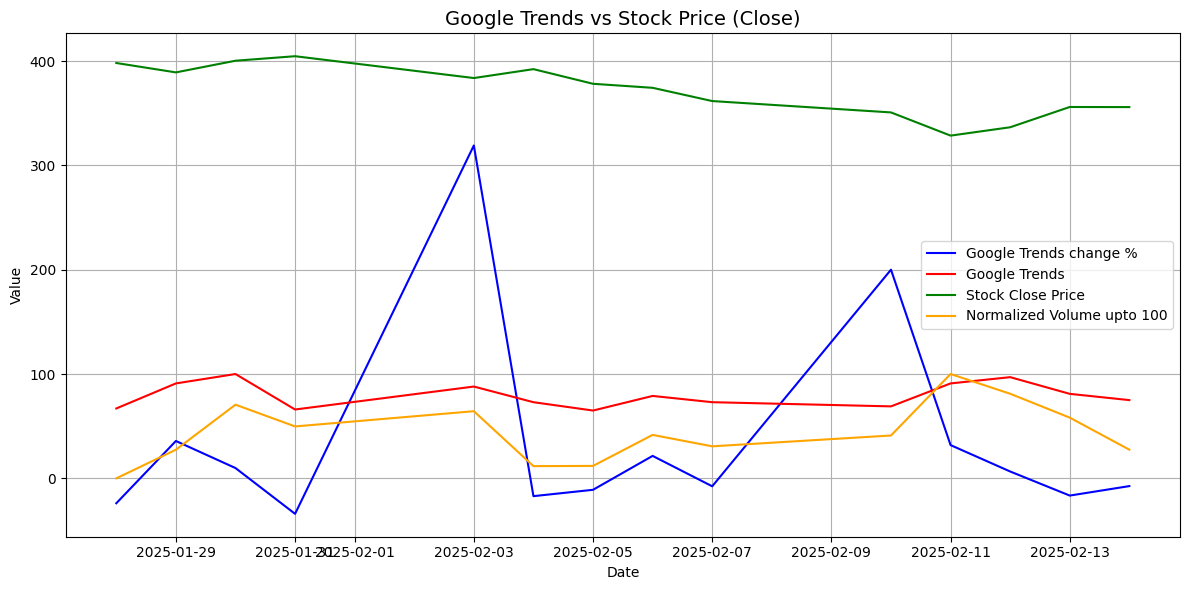

In [16]:
#@title Merge Google trend data with OHLCV for a given stock data
import pandas as pd
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import time
from datetime import date, timedelta


class StockTrendAnalysis:
    def __init__(self, search_term, timeframe='today 3-m', geo='', gprop=''):
        """
        Initializes the StockTrendAnalysis class with the search term and trend parameters.

        Parameters:
        search_term (str): The search term to query on Google Trends.
        timeframe (str): Timeframe for the trends (e.g., 'today 3-m').
        geo (str): Geographical region for the trends.
        gprop (str): Type of data (e.g., 'news' for news-related trends).
        """
        self.search_term = search_term
        self.timeframe = timeframe
        self.geo = geo
        self.gprop = gprop
        self.trend_data = None
        self.stock_data = None
        self.merged_data = None

    def download_trend_data(self):
        """
        Downloads Google Trends data for a given search term and timeframe.

        Returns:
        pd.DataFrame: A DataFrame containing the trend data for the search term.
        """
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload([self.search_term], cat=0, timeframe=self.timeframe, geo=self.geo, gprop=self.gprop)
        self.trend_data = pytrends.interest_over_time()
        return self.trend_data

    def calculate_trend_percentage(self):
        """
        Calculates the percentage change in the trend over the given period.

        Returns:
        pd.DataFrame: DataFrame containing Google Trends data with Trend_Percentage column.
        """
        self.trend_data['Trend_Percentage'] = self.trend_data['Tesla stock'].pct_change() * 100
        return self.trend_data

    def get_timeframe(self, days_back):
        """
        Generates a Google Trends timeframe string for the specified number of days back.

        Parameters:
        days_back (int): The number of days to go back from today.

        Returns:
        str: The Google Trends timeframe string in the format 'YYYY-MM-DD YYYY-MM-DD'.
        """
        end_date = date.today()
        start_date = end_date - timedelta(days=days_back)
        timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"
        return timeframe

    def download_ohlcv_data(self, ticker, start_date, end_date):
        """
        Downloads OHLCV data from Yahoo Finance.

        Parameters:
        ticker (str): The stock ticker (e.g., 'TSLA' for Tesla).
        start_date (str): Start date of the data in 'YYYY-MM-DD' format.
        end_date (str): End date of the data in 'YYYY-MM-DD' format.

        Returns:
        pd.DataFrame: DataFrame containing OHLCV data.
        """
        self.stock_data = yf.download(ticker, start=start_date, end=end_date)
        return self.stock_data

    def align_data(self):
        """
        Aligns Google Trends data with stock OHLCV data based on the date index.

        Returns:
        pd.DataFrame: Merged DataFrame with both Google Trends and stock OHLCV data.
        """
        # Reset index of stock_data to single-level index with 'Date' as a column
        self.stock_data = self.stock_data.reset_index()

        # Convert 'Date' column in both trend_data and stock_data to datetime format
        self.trend_data.index = pd.to_datetime(self.trend_data.index)
        self.trend_data.reset_index(inplace=True)
        # Rename the 'date' column to 'Date' before converting to datetime
        self.trend_data.rename(columns={'date': 'Date'}, inplace=True)

        # Remove the second level and keep only the first level of the column names
        self.stock_data.columns = self.stock_data.columns.get_level_values(0)
        print("\nStock Data Info:")
        print(self.stock_data.info())
        print("\ntrend Data Info:")
        print(self.trend_data.info())

        # Ensure 'Date' columns are datetime type
        self.stock_data['Date'] = pd.to_datetime(self.stock_data['Date'])
        self.trend_data['Date'] = pd.to_datetime(self.trend_data['Date'])

        # Merge Google Trends and OHLCV data on the 'Date' column
        self.merged_data = pd.merge(self.stock_data, self.trend_data, on='Date', how='inner')

        # Set 'Date' column as index for merged_data
        self.merged_data = self.merged_data.set_index('Date')

        # Ensure there are no missing values
        self.merged_data = self.merged_data.dropna()

        return self.merged_data

    def normalize_volume(self):
        """
        Normalizes the volume of the stock data.

        Returns:
        pd.DataFrame: DataFrame with normalized volume.
        """
        volume_min = self.merged_data['Volume'].min()
        volume_max = self.merged_data['Volume'].max()
        self.merged_data['VolumeNormalized'] = ((self.merged_data['Volume'] - volume_min) / (volume_max - volume_min)) * 100
        return self.merged_data

    def calculate_correlation(self):
        """
        Calculate Pearson correlation between Google Trends data and stock OHLCV data.

        Returns:
        pd.Series: Correlation between Google Trends and stock OHLCV columns.
        """
        correlation = self.merged_data.corr()
        return correlation

    def plot_correlation(self):
        """
        Visualizes the relationship between Google Trends and stock data.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.merged_data.index, self.merged_data['Trend_Percentage'], label='Google Trends change %', color='blue')
        plt.plot(self.merged_data.index, self.merged_data['Tesla stock'], label='Google Trends', color='red')
        plt.plot(self.merged_data.index, self.merged_data['Close'], label='Stock Close Price', color='green')
        plt.plot(self.merged_data.index, self.merged_data['VolumeNormalized'], label='Normalized Volume upto 100', color='orange')
        plt.title('Google Trends vs Stock Price (Close)', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def get_timeframe(days_back):
        """
        Generates a Google Trends timeframe string for the specified number of days back.

        Parameters:
        days_back (int): The number of days to go back from today.

        Returns:
        str: The Google Trends timeframe string in the format 'YYYY-MM-DD YYYY-MM-DD'.
        """
        end_date = date.today()
        start_date = end_date - timedelta(days=days_back)
        timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"
        return timeframe


# Example Usage
if __name__ == "__main__":
    # Create an instance of StockTrendAnalysis class for "Tesla stock"
    stock_trend_analysis = StockTrendAnalysis(search_term='Tesla stock', timeframe=StockTrendAnalysis.get_timeframe(20))

    # Download Google Trends data for "Tesla stock"
    trend_data = stock_trend_analysis.download_trend_data()

    # Calculate trend percentage
    trend_data = stock_trend_analysis.calculate_trend_percentage()

    # Download stock OHLCV data for Tesla
    stock_data = stock_trend_analysis.download_ohlcv_data(ticker='TSLA', start_date='2024-11-15', end_date='2025-02-15')

    # Align the data
    merged_data = stock_trend_analysis.align_data()

    # Normalize Volume data
    merged_data = stock_trend_analysis.normalize_volume()

    # Calculate the correlation between Google Trends and stock data
    correlation = stock_trend_analysis.calculate_correlation()
    print("Correlation between Google Trends and Stock Data:")
    print(correlation)

    # Plot the trends and stock data
    stock_trend_analysis.plot_correlation()
